In [1]:
import sys
sys.path.append('/home/sarrah/clean/CLEAN')

In [2]:
from CLEAN.infer import infer_maxsep
from CLEAN.utils import * 
from app.src.CLEAN.model import LayerNormNet
from app.src.CLEAN.distance_map import *
from app.src.CLEAN.evaluate import *
import subprocess
import pandas as pd

/home/sarrah/miniconda3/envs/clean/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def retrieve_esm1b_embedding(fasta_name):
    esm_script = "/home/sarrah/clean/CLEAN/app/esm/scripts/extract.py"
    esm_out = "/home/sarrah/clean/CLEAN/app/data/esm_data"
    esm_type = "esm1b_t33_650M_UR50S"
    fasta_name = "/home/sarrah/clean/CLEAN/app/testing/data/" + fasta_name + ".fasta"
    command = ["python", esm_script, esm_type, 
              fasta_name, esm_out, "--include", "mean"]
    subprocess.run(command)

#Note I deleted Hyer-7 because it had 47 in it and this one >MaybeCbAgo and I deleted the first 2 rows


In [4]:
retrieve_esm1b_embedding('sarrahtestset')

Transferred model to GPU
Read /home/sarrah/clean/CLEAN/app/testing/data/sarrahtestset.fasta with 36 sequences
Processing 1 of 10 batches (9 sequences)
Processing 2 of 10 batches (6 sequences)
Processing 3 of 10 batches (6 sequences)
Processing 4 of 10 batches (3 sequences)
Processing 5 of 10 batches (3 sequences)
Processing 6 of 10 batches (3 sequences)
Processing 7 of 10 batches (2 sequences)
Processing 8 of 10 batches (2 sequences)
Processing 9 of 10 batches (1 sequences)
Processing 10 of 10 batches (1 sequences)


In [11]:
#Generate CSV file for fasta file
def fasta_to_csv(fasta_name):
    csvfile = open('/home/sarrah/clean/CLEAN/app/testing/data/' + fasta_name +'.csv', 'w', newline='')
    csvwriter = csv.writer(csvfile, delimiter = '\t')
    csvwriter.writerow(['Entry', 'EC number', 'Sequence'])
    fastafile = open('./data/' + fasta_name +'.fasta', 'r')
    for i in fastafile.readlines():
        if i[0] == '>':
            csvwriter.writerow([i.strip()[1:], ' ', ' '])

In [12]:
fasta_to_csv('sarrahtestset')

In [8]:
#pretend I have a training csv file for inference    
train_data = "/home/sarrah/clean/CLEAN/app/data/split100"
test_data = "/home/sarrah/clean/CLEAN/app/testing/data/sarrahtestset"


In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
dtype = torch.float32
id_ec_train, ec_id_dict_train = get_ec_id_dict(train_data  + '.csv')
id_ec_test, _ = get_ec_id_dict(test_data + '.csv')


In [11]:
emb_train = torch.load('/home/sarrah/clean/CLEAN/app/data/pretrained/100.pt', map_location=device)

In [30]:
model = LayerNormNet(512, 128, device, dtype)
checkpoint = torch.load('/home/sarrah/clean/CLEAN/app/data/pretrained/split100.pth', map_location=device)
model.load_state_dict(checkpoint)
model.eval()
emb_train = torch.load('/home/sarrah/clean/CLEAN/app/data/pretrained/100.pt', map_location=device)

In [28]:
def load_esm(lookup):
    esm = format_esm(torch.load('/home/sarrah/clean/CLEAN/app/data/esm_data/' + lookup + '.pt'))
    return esm.unsqueeze(0)

def model_embedding_test_new(id_ec_test, model, device, dtype):
    ids_for_query = list(id_ec_test.keys())
    esm_to_cat = [load_esm(id) for id in ids_for_query]
    esm_emb = torch.cat(esm_to_cat).to(device=device, dtype=dtype)
    model_emb = model(esm_emb)
    return model_emb

In [31]:
emb_test = model_embedding_test_new(id_ec_test, model, device, dtype)
eval_dist = get_dist_map_test(emb_train, emb_test, ec_id_dict_train, id_ec_test, device, dtype)
seed_everything()
eval_df = pd.DataFrame.from_dict(eval_dist)
out_filename = test_data
write_max_sep_choices(eval_df, out_filename, gmm=None)


The embedding sizes for train and test: torch.Size([241025, 128]) torch.Size([36, 128])


100%|██████████| 5242/5242 [00:00<00:00, 20402.70it/s]


Calculating eval distance map, between 36 test ids and 5242 train EC cluster centers


36it [00:00, 398.19it/s]


In [10]:
eval_dist['PE']

{'2.7.10.2': 13.541834,
 '3.5.2.6': 11.575012,
 '2.3.2.27': 12.036507,
 '3.4.22.53': 15.474697,
 '3.4.22.54': 14.565556,
 '3.4.21.42': 14.321396,
 '4.2.1.1': 12.866025,
 '1.5.1.5': 15.523744,
 '3.5.4.9': 15.505314,
 '6.3.4.3': 15.531229,
 '2.5.1.48': 15.990476,
 '2.7.12.2': 14.397781,
 '2.7.11.22': 15.043053,
 '2.7.7.85': 11.332207,
 '3.1.3.36': 14.826938,
 '1.21.99.3': 16.244118,
 '4.1.2.40': 13.880176,
 '2.3.1.199': 16.282887,
 '1.14.99.66': 13.072156,
 '1.14.11.66': 14.83011,
 '2.7.3.2': 12.805199,
 '3.4.19.12': 12.136303,
 '2.7.1.91': 16.589828,
 '2.3.1.297': 16.342915,
 '1.1.1.27': 16.62717,
 '2.7.1.40': 14.593969,
 '3.4.21.53': 13.882705,
 '1.13.11.34': 15.296936,
 '3.1.1.3': 15.2699995,
 '3.1.1.5': 14.091504,
 '3.1.1.32': 13.46835,
 '1.4.3.20': 14.973003,
 '3.1.1.79': 16.615213,
 '3.1.1.23': 15.545967,
 '2.3.1.23': 15.998531,
 '2.3.1.n6': 16.750174,
 '2.3.1.121': 17.635118,
 '2.3.1.67': 17.37621,
 '2.3.1.n7': 16.508745,
 '4.1.1.33': 16.813694,
 '2.7.1.11': 14.083253,
 '3.2.1.15'

In [49]:
out_filename+'_maxsep.csv'

'/home/sarrah/clean/CLEAN/app/testing/data/sarrahtestset_maxsep.csv'

In [57]:
#probably need to find a better way to keep track of ordering - currently just tracking indexing in csv file
EC_clusters = {}
i = 0 
with open(out_filename+'_maxsep.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        # Process each row
        seq_id = row[0]
        first_EC = row[1].split('/')[0][3:].split('.')[0]
        
        if first_EC not in EC_clusters: 
            EC_clusters[first_EC] = {}
        EC_clusters[first_EC][seq_id] = i
        i += 1
        

In [68]:
EC_clusters['3']

{'PE': 0,
 'CBE': 1,
 'ABE': 2,
 'SaCas9': 3,
 'SpCas9': 4,
 'SpRY': 5,
 'Cas12i_chainA': 6,
 'Cas12f1': 7,
 'Cas12a_andgRNA': 8,
 'RfxCas13d_andgRNA_drosophilia': 9,
 'Fanzor_TDe': 10,
 'Fanzor_SCe_ORF9': 11,
 'Tnpb': 12,
 'Argonaute2_AGO2': 13,
 'SHtnsb': 23,
 'ShTnsC': 24,
 'ShCas12k': 26,
 'I-SceI': 28,
 'EcoRI': 30,
 'Alt_Control_26_5': 34}

In [58]:
EC_clusters

{'3': {'PE': 0,
  'CBE': 1,
  'ABE': 2,
  'SaCas9': 3,
  'SpCas9': 4,
  'SpRY': 5,
  'Cas12i_chainA': 6,
  'Cas12f1': 7,
  'Cas12a_andgRNA': 8,
  'RfxCas13d_andgRNA_drosophilia': 9,
  'Fanzor_TDe': 10,
  'Fanzor_SCe_ORF9': 11,
  'Tnpb': 12,
  'Argonaute2_AGO2': 13,
  'SHtnsb': 23,
  'ShTnsC': 24,
  'ShCas12k': 26,
  'I-SceI': 28,
  'EcoRI': 30,
  'Alt_Control_26_5': 34},
 '5': {'MpAgo_Doudna_Hydroxylatedguides': 14,
  'topoisomerase1': 31,
  'topoisomerase2': 32},
 '2': {'HYER_5': 15,
  'HYER_1': 16,
  'HYER_8': 17,
  'HYER_9': 18,
  'HYER_4': 19,
  'HYER_6': 20,
  'HYER_2': 21,
  'HYER_3': 22,
  'ShTniQ': 25,
  'FEN1': 27,
  'RecB': 29,
  'Control_EC_3_1_26_5': 33},
 '1': {'Control_EC_3_1_21_4': 35}}

In [88]:
intra_cluster_distances = {}
i=0
for EC in EC_clusters: 
    print(f'Round {i}')
    print(EC)
    #Select the embeddings and put them all into one tensor
    EC_specific_embeddings = [emb_test[i] for i in EC_clusters[EC].values()]
    EC_specific_embeddings_tensor = torch.stack(EC_specific_embeddings)

    EC_specific_embeddings_tensor = F.normalize(EC_specific_embeddings_tensor, dim=-1, p=2)
    distances = torch.cdist(EC_specific_embeddings_tensor, EC_specific_embeddings_tensor, p=2)
    intra_cluster_distances[EC] = distancesx
    i+=1

Round 0
3
Round 1
5
Round 2
2
Round 3
1


In [25]:
ids = list(id_ec_test.keys())

In [24]:
def dist_map_helper(keys1, lookup1):
    dist = {}
    for i, key1 in tqdm(enumerate(keys1)):
        current = lookup1[i].unsqueeze(0)
        dist_norm = (current - lookup1).norm(dim=1, p=2)
        dist_norm = dist_norm.detach().cpu().numpy()
        dist[key1] = {}
        for j, key2 in enumerate(keys1):
            dist[key1][key2] = dist_norm[j]
    return dist


In [32]:
validate = dist_map_helper(ids, emb_test)

36it [00:00, 8576.33it/s]


In [33]:
validate

{'PE': {'PE': 0.0,
  'CBE': 4.3609457,
  'ABE': 7.6962085,
  'SaCas9': 6.732674,
  'SpCas9': 5.991786,
  'SpRY': 6.035469,
  'Cas12i_chainA': 9.108842,
  'Cas12f1': 9.992898,
  'Cas12a_andgRNA': 6.8676434,
  'RfxCas13d_andgRNA_drosophilia': 11.076632,
  'Fanzor_TDe': 11.184972,
  'Fanzor_SCe_ORF9': 10.885393,
  'Tnpb': 10.329845,
  'Argonaute2_AGO2': 16.040537,
  'MpAgo_Doudna_Hydroxylatedguides': 11.134186,
  'HYER_5': 14.902077,
  'HYER_1': 14.819606,
  'HYER_8': 16.384148,
  'HYER_9': 16.34869,
  'HYER_4': 14.631546,
  'HYER_6': 14.873454,
  'HYER_2': 14.792981,
  'HYER_3': 14.698568,
  'SHtnsb': 11.466024,
  'ShTnsC': 11.466024,
  'ShTniQ': 11.865072,
  'ShCas12k': 9.785981,
  'FEN1': 12.862443,
  'I-SceI': 11.29134,
  'RecB': 11.090373,
  'EcoRI': 8.827951,
  'topoisomerase1': 11.019719,
  'topoisomerase2': 12.009664,
  'Control_EC_3_1_26_5': 16.46747,
  'Alt_Control_26_5': 8.851166,
  'Control_EC_3_1_21_4': 11.977948},
 'CBE': {'PE': 4.3609457,
  'CBE': 0.0,
  'ABE': 5.364761,
  

In [ ]:
intra_cluster_distances = {}
i=0
for EC in EC_clusters: 
    print(f'Round {i}')
    print(EC)
    #Select the embeddings and put them all into one tensor
    EC_specific_embeddings = [emb_test[i] for i in EC_clusters[EC].values()]
    EC_specific_embeddings_tensor = torch.stack(EC_specific_embeddings)

    EC_specific_embeddings_tensor = F.normalize(EC_specific_embeddings_tensor, dim=-1, p=2)
    distances = torch.cdist(EC_specific_embeddings_tensor, EC_specific_embeddings_tensor, p=2)
    intra_cluster_distances[EC] = distancesx
    i+=1

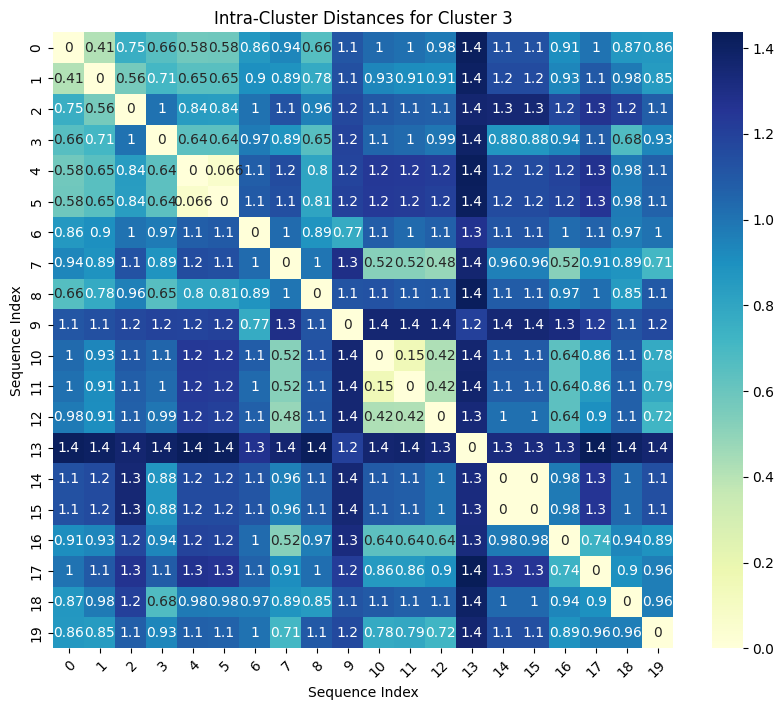

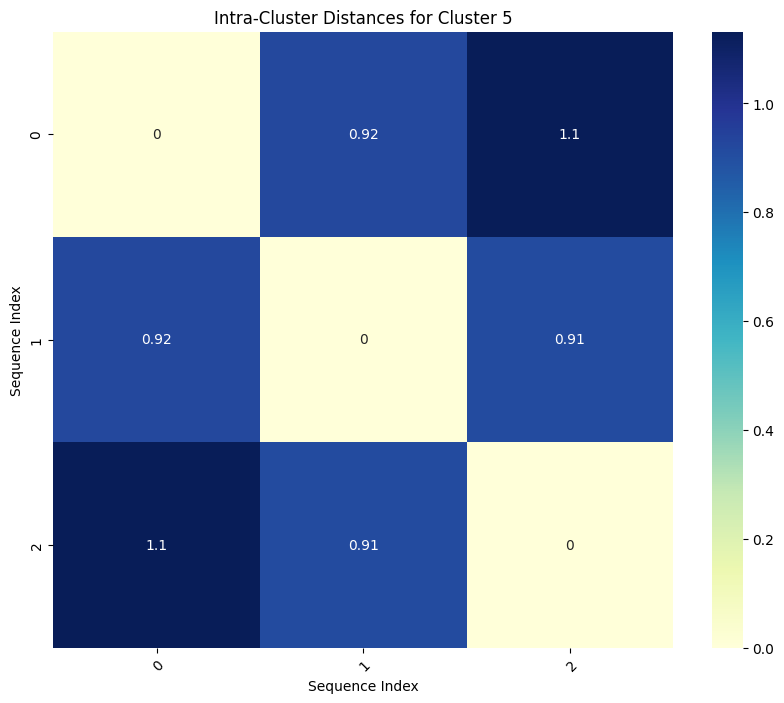

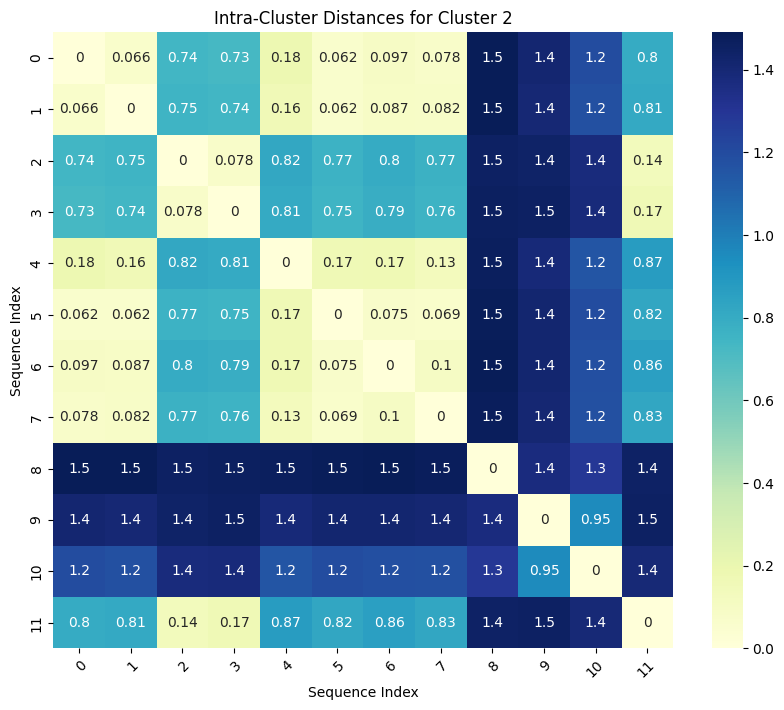

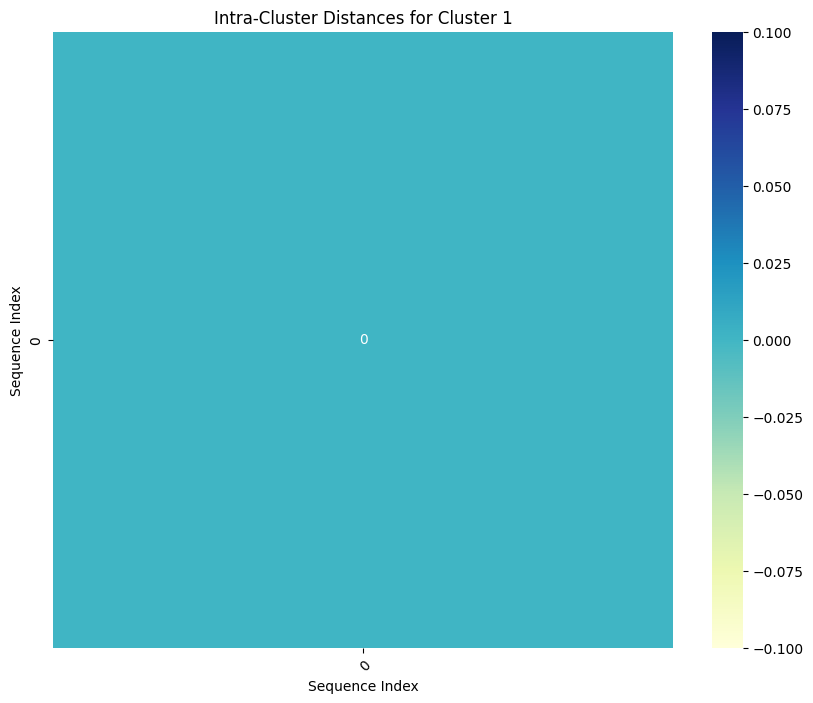

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming intra_cluster_distances is a dictionary where keys are cluster labels
# and values are the corresponding distance matrices

# Iterate over the dictionary to create a heatmap for each cluster
for cluster_label, distance_matrix in intra_cluster_distances.items():

    distance_matrix = distance_matrix.cpu().detach().numpy()
    # Create a heatmap
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(distance_matrix, annot=True, cmap="YlGnBu", ax=ax)
    
    # Add title and axis labels
    ax.set_title(f"Intra-Cluster Distances for Cluster {cluster_label}")
    ax.set_xlabel("Sequence Index")
    ax.set_ylabel("Sequence Index")
    
    # Rotate x-axis tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    
    # Show the heatmap
    plt.show()

In [13]:
#Method of validation is seeing is this technique works on matching the cluster distances

cluster_center_model = get_cluster_center(emb_train, ec_id_dict_train)

100%|██████████| 5242/5242 [00:00<00:00, 12565.78it/s]


In [14]:
cluster_center_model

{'2.7.10.2': tensor([ 0.5684, -0.2730,  1.3413, -0.0455,  0.5519, -0.5602,  0.4452,  0.3555,
         -0.3990,  0.8149, -0.7487,  0.8769, -0.0774, -1.2195, -0.3510,  0.3407,
          0.6935, -0.4897, -0.6786,  0.4822, -0.4402,  0.1503,  0.6215, -0.2650,
          1.0949,  0.4402,  0.4229,  1.4833,  0.2911, -2.0526, -1.0108,  0.8270,
          0.0103, -0.4963,  0.4265,  0.6308, -0.5499, -1.2763, -0.9737,  0.3145,
         -0.9146,  0.4415,  0.2394,  0.2096,  0.0948, -0.6719,  0.1269, -0.6432,
          1.3322,  0.8958,  0.2907,  1.5833,  1.6047,  0.0427, -0.1019, -0.1428,
          0.6814, -0.9868,  0.4500,  0.1787, -0.3415,  1.0227,  0.2722,  0.2320,
          0.5672, -0.8140, -0.4843,  0.3830, -1.4036, -0.3750, -2.0639, -0.9057,
         -1.1886,  0.3434, -1.0756, -1.4245,  1.1373, -0.1440, -0.1108, -2.4469,
          0.1129, -0.2940,  0.3541,  0.9514, -0.1508, -1.1097, -0.3776,  0.0645,
          0.1616, -0.3648,  0.8489, -0.1049,  0.1043, -0.9301,  0.1868,  0.8923,
          0.1699

In [19]:
total_ec_n, out_dim = len(ec_id_dict_train.keys()), emb_train.size(1)
model_lookup = torch.zeros(total_ec_n, out_dim, device=device, dtype=dtype)
ecs = list(cluster_center_model.keys())
for i, ec in enumerate(ecs):
    model_lookup[i] = cluster_center_model[ec]
model_lookup = model_lookup.to(device=device, dtype=dtype)

In [22]:
model_lookup.shape

torch.Size([5242, 128])